<a href="https://colab.research.google.com/github/Donaldwic/Markov-Switching-Model/blob/main/QuantCU_MSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Math behind Markov Switching Model

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.regime_switching.markov_regression import MarkovRegression

# Import data

In [19]:
# Step 1: Download Stock Price Data
ticker="BTC-USD"
stock_data = yf.download(ticker, start="2014-01-01", end="2024-12-22")
stock_data['Log Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
stock_data.dropna(inplace=True)

[*********************100%***********************]  1 of 1 completed


# Find Probability of switching regime

In [25]:
# Step 2: Train Markov Switching Model
# Fit a Markov Switching Model with two states on the log returns
ms_model = MarkovRegression(stock_data['Log Returns'], k_regimes=2, trend='c', switching_variance=True)
ms_result = ms_model.fit()

# Print Transition Matrix
transition_matrix = np.array(ms_result.regime_transition).T
print("\nEstimated Transition Matrix:")
print(transition_matrix[:, :][0])  # Extract the 2D matri

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)



Estimated Transition Matrix:
[[0.87717818 0.12282182]
 [0.19871326 0.80128674]]


# How the model know which state we are?
- Find $\mu_1,\mu_2, \sigma_1^2, \sigma_2^2$
- Put them on likelihood function, if $f_t(1)>f_t(2)$ it's regime 1 (bull market)

before we know $\mu_k,\sigma_k^2$ how the model know which data is in regime 1 or 2?


## Example Walkthrough

Suppose we have:
- **Observations**: $ Y = [0.01, 0.02, -0.01, 0.03, -0.02] $.
- **Two regimes**: Regime 1 and Regime 2.

### Step 1
- Initial $ \mu_1 = 0.01, \mu_2 = -0.01 $.
- Initial $ \sigma_1^2 = 0.0001, \sigma_2^2 = 0.001 $.

### Step 2
- Calculate $ \xi_t(1) $ and $ \xi_t(2) $ (probabilities of each regime for each \( y_t \)) using the forward-backward algorithm.

### Step 3
- Update $\mu_1 $ and $ \mu_2 $:

$$
\mu_1 = \frac{\sum_{t=1}^T \xi_t(1) \cdot y_t}{\sum_{t=1}^T \xi_t(1)}
$$


$$\mu_2 = \frac{\sum_{t=1}^T \xi_t(2) \cdot y_t}{\sum_{t=1}^T \xi_t(2)}
$$

- Update $\sigma_1^2 \text{ and } \sigma_2^2 $.

$$\sigma_1^2 = \frac{\sum_{t=1}^T \xi_t(1) \cdot (y_t - \mu_1)^2}{\sum_{t=1}^T \xi_t(1)}$$

$$\sigma_k^2 = \frac{\sum_{t=1}^T \xi_t(2) \cdot (y_t - \mu_2)^2}{\sum_{t=1}^T \xi_t(2)}$$

Repeat until convergence.

#The method of calculating probability


# How the Model Determines the State (Regime 1 or 2)

The Markov Switching Model (MSM) does not directly observe the state at any specific time. Instead, it estimates probabilities for being in each state using the observed data and model parameters. The following steps outline how the model determines the most likely state:

## 1. Hidden Markov States

The model assumes that the observed data ($y_t$) are generated by a hidden state process ($s_t$) that evolves according to a Markov process. The hidden states are governed by a transition matrix:

$$
P =
\begin{bmatrix}
P_{00} & P_{01} \\\\
P_{10} & P_{11}
\end{bmatrix}
$$

where:

- $P_{ij}$: Probability of transitioning from state $i$ to state $j$.

The hidden state $s_t$ determines the parameters of the distribution generating the data at time $t$.

## 2. Likelihood of Observations

Each state $k$ is associated with a unique set of parameters, such as the mean ($\mu_k$) and variance ($\sigma_k^2$). The likelihood of observing $y_t$ in state $k$ is given by:

$$
f_t(k) = P(y_t \mid s_t = k)
$$

For example, if $y_t$ is assumed to follow a normal distribution:

$$
f_t(k) = \frac{1}{\sqrt{2\pi \sigma_k^2}} \exp\left(-\frac{(y_t - \mu_k)^2}{2\sigma_k^2}\right)
$$

## 3. Forward-Backward Algorithm

The model uses the forward-backward algorithm to calculate probabilities for being in each state:

### (a) Forward Probability ($\alpha_t(k)$)

The forward probability is the probability of being in state $k$ at time $t$ given the data up to time $t$:

$$
\alpha_t(k) = \sum_{j=1}^{K} \alpha_{t-1}(j) P_{jk} f_t(k)
$$

where:

- $\alpha_{t-1}(j)$: Probability of being in state $j$ at $t-1$.
- $P_{jk}$: Probability of transitioning from state $j$ to $k$.
- $f_t(k)$: Likelihood of observing $y_t$ given state $k$.

### (b) Backward Probability ($\beta_t(k)$)

The backward probability is the probability of observing future data ($y_{t+1}, y_{t+2}, \dots$) given that we are in state $k$ at time $t$:

$$
\beta_t(k) = \sum_{j=1}^{K} P_{kj} f_{t+1}(j) \beta_{t+1}(j)
$$

### (c) Smoothed Probability ($\xi_t(k)$)

The smoothed probability combines forward and backward probabilities to estimate the probability of being in state $k$ at time $t$, given all the data:

$$
\xi_t(k) = P(s_t = k \mid Y) = \frac{\alpha_t(k) \beta_t(k)}{\sum_{j=1}^{K} \alpha_t(j) \beta_t(j)}
$$

## 4. Determining the Most Likely State

To identify the most likely state at time $t$, the model selects the state with the highest smoothed probability:

$$
\text{Dominant Regime at } t = \arg\max_k \xi_t(k)
$$

For example, if:

$$
\xi_t(1) = 0.7 \quad \text{and} \quad \xi_t(2) = 0.3
$$

then the model assigns $s_t = 1$ (state 1).




In [21]:
# Step 3: Get Smoothed Regime Probabilities
smoothed_probabilities = ms_result.smoothed_marginal_probabilities

# Step 4: Determine Dominant Regime
dominant_regimes = smoothed_probabilities.idxmax(axis=1)

# Plot Market State

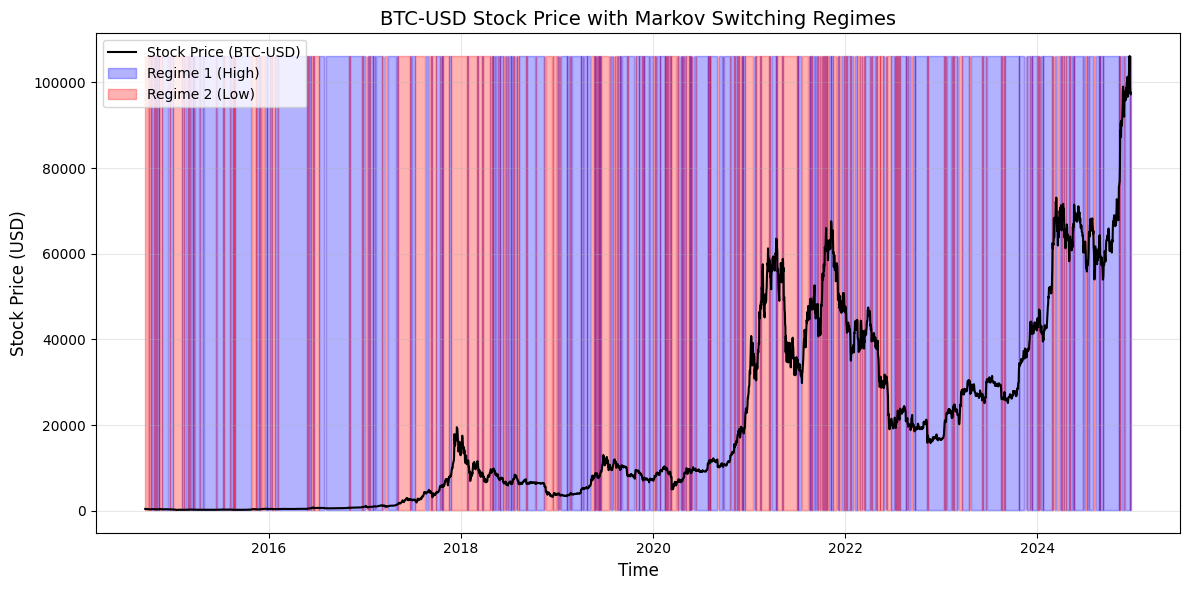

In [22]:
# Step 5: Plot Actual Stock Price with Regimes
plt.figure(figsize=(12, 6))

# Plot actual stock price
plt.plot(stock_data['Close'], label=f"Stock Price ({ticker})", color="black", lw=1.5)

# Highlight states
plt.fill_between(stock_data.index, stock_data['Close'].min(), stock_data['Close'].max(),
                 where=(dominant_regimes == 0), color='blue', alpha=0.3, label="Regime 1 (High)")
plt.fill_between(stock_data.index, stock_data['Close'].min(), stock_data['Close'].max(),
                 where=(dominant_regimes == 1), color='red', alpha=0.3, label="Regime 2 (Low)")

# Labels and legend
plt.title(f"{ticker} Stock Price with Markov Switching Regimes", fontsize=14)
plt.xlabel("Time", fontsize=12)
plt.ylabel("Stock Price (USD)", fontsize=12)
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()